In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from PIL import Image

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random
import torch
from PIL import Image
import requests

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


In [83]:
#these codes are used to loop through the directory
path_images = 'rs19_val/jpgs/rs19_val/'
path_images_resized = 'rs19_val/images_resized/'
path_masks = 'rs19_val/uint8/rs19_val/'
path_masks_resized = 'rs19_val/masks_resized/'


# read the tram list and turn it into a dict
tram_list = pd.read_csv('tram_filenames.csv')
tram_dict = tram_list.iloc[:,1:].to_dict()

In [86]:
image = mpimg.imread("rs19_val/jpgs/rs19_val/rs04744.jpg")
mask_original=  mpimg.imread("rs19_val/uint8/rs19_val/rs04744.png")

image_resized = mpimg.imread("rs19_val/images_resized/rs04744.jpg")
mask_original_resized=mpimg.imread("rs19_val/masks_resized/rs04744.png")

Text(0.5, 1.0, 'Original Image with (1080, 1920, 3) shape')

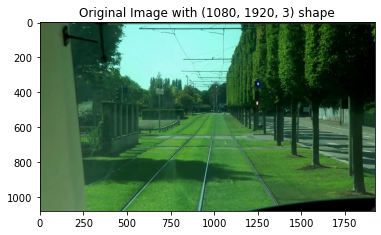

In [94]:
plt.imshow(image)
plt.title('Original Image with '+ str(image.shape)+' shape')

Text(0.5, 1.0, 'Resized Image with (256, 256, 3) shape')

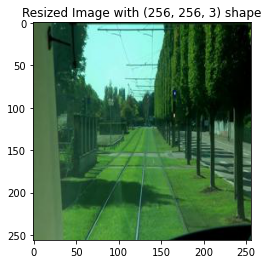

In [95]:
plt.imshow(image_resized)
plt.title('Resized Image with '+ str(image_resized.shape)+' shape')

In [96]:
gray = cv2.cvtColor(np.array(image_resized),cv2.COLOR_RGB2GRAY)

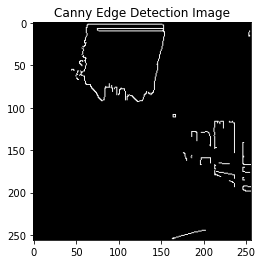

In [97]:
# Do all the relevant imports


# Read in the image and convert to grayscale
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
#image = mpimg.imread("rs19_val/jpgs/rs19_val/rs00267.jpg")
#image_resized= 
#gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 5 # Must be an odd number (3, 5, 7...)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and run it
low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.title("Canny Edge Detection Image")
plt.show()

# Create masked edge image of the resized image using cv2.fillPoly()

In [98]:
#image = mpimg.imread("rs19_val/jpgs/rs19_val/rs00267.jpg")
#gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
#kernel_size = 5
#blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
#low_threshold = 180
#high_threshold = 240
#edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = np.array(image_resized).shape
vertices = np.array([[(0,imshape[0]),(120, 150), (135, 150), (imshape[1],imshape[0])]], dtype=np.int32)
mask = np.zeros_like(edges)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)


# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 2     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4 #minimum number of pixels making up a line
max_line_gap = 5    # maximum gap in pixels between connectable line segments
line_image = np.copy(image_resized)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)
# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)


# View the results

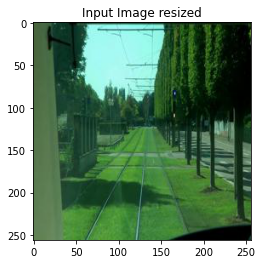

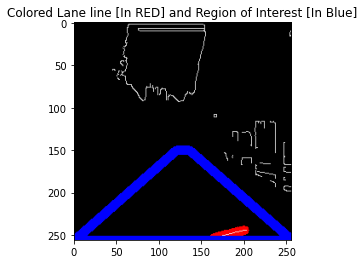

In [99]:
plt.imshow(image_resized)
plt.title("Input Image resized")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()

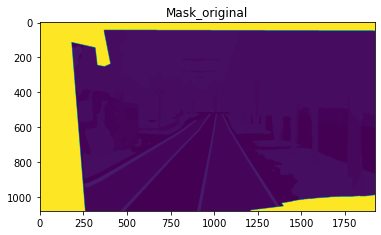

In [103]:
plt.imshow(mask_original)
plt.title("Mask_original")
plt.show()

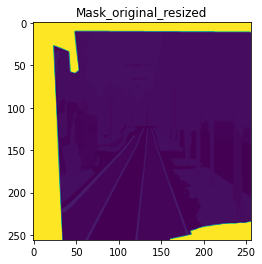

In [104]:
#img_mask = mpimg.imread("rs19_val/uint8/rs19_val/rs00267.png")
 #veg
# VEG-FOCUSED mask
#img_mask[img_mask!=label_of_interest]=0
#img_mask[img_mask==label_of_interest]=1
#img_mask[img_mask!=0]=8
plt.imshow(mask_original_resized)
plt.title("Mask_original_resized")
plt.show()





In [101]:
mask_original_resized

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [105]:
"""
Step 3 & 4 explanation:
If pixel_value = veg and depth_value != 0 then:
    pixel_value = veg
Else:
    pixel_value = 0
"""



dataset_mask_multiplied = mask_original_resized * mask


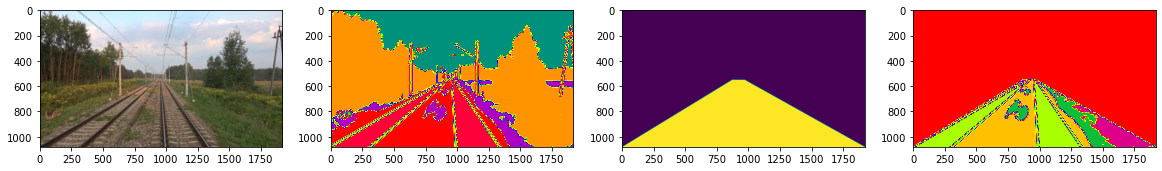

In [7]:
index = 22
f, axis_arr = plt.subplots(1,4, figsize=(20,20)) 
axis_arr[0].imshow(image)
axis_arr[1].imshow(img_mask, cmap='prism')
axis_arr[2].imshow(mask)
axis_arr[3].imshow(dataset_mask_multiplied, cmap='prism')

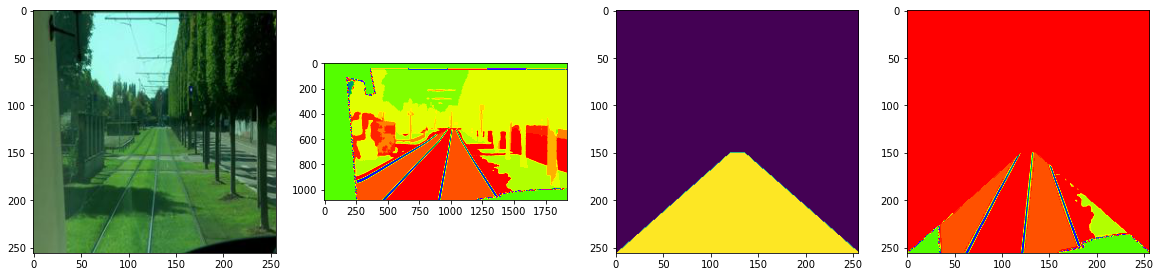

In [106]:
index = 22
f, axis_arr = plt.subplots(1,4, figsize=(20,20)) 
axis_arr[0].imshow(image_resized)
axis_arr[1].imshow(mask_original, cmap='prism')
axis_arr[2].imshow(mask)
axis_arr[3].imshow(dataset_mask_multiplied, cmap='prism')